In [57]:
# !pip install xgboost
# !pip install shap
# !conda install -y -c dglteam dgl-cuda10.1
# !conda install -y pytorch torchvision cudatoolkit=10.1 -c pytorch

In [90]:
import os
from pathlib import Path

import pickle
import xgboost as xgb
import shap

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.datasets import load_iris, load_digits, load_boston
import matplotlib.pyplot as plt

In [91]:
results_dir = '/data/results/08282020'
Path(results_dir).mkdir(parents=True, exist_ok=True)

In [60]:
df = pd.read_csv('/data/results/ucec_test_2.tsv', sep='\t', index_col='Unnamed: 0')
df

,acetylome_value,acetylome_paired_value,acetylome_paired_difference,phosphoproteome_value,phosphoproteome_paired_value,phosphoproteome_paired_difference,has_mutation,driver,expanded_driver
ACIN1_S001,0.384000,-0.33100,0.715000,-0.115003,0.082828,-0.197831,True,0,0
ACIN1_S017,0.014600,-0.63800,0.652600,0.199073,-0.098946,0.298019,False,0,0
ACIN1_S021,0.619000,-1.15000,1.769000,0.269939,-0.002826,0.272765,False,0,0
ACIN1_S022,0.245000,-0.91800,1.163000,0.173390,-0.058451,0.231841,True,0,0
ACIN1_S023,-0.247000,0.05590,-0.302900,0.067890,0.220426,-0.152536,False,0,0
...,...,...,...,...,...,...,...,...,...
ZYX_S079,-0.658000,0.04085,-0.698850,-0.311935,0.298645,-0.610580,False,0,0
ZYX_S086,-0.521500,-0.19000,-0.331500,-0.269828,0.012692,-0.282520,False,0,0
ZYX_S087,-0.040500,0.21900,-0.259500,-0.511296,0.331604,-0.842900,False,0,0
ZYX_S091,-0.054515,0.45050,-0.505015,-0.499086,1.621847,-2.120933,False,0,0


In [61]:
# df = df[[c for c in df.columns if c not in ['value', 'data_type']]]
# df.index = [x.split('_')[0] + '_' + x.split('_')[2] for x in df.index]
# df = df.drop_duplicates()

In [67]:
df['gene'] = [g.split('_')[0] for g in df.index]
df

,acetylome_value,acetylome_paired_value,acetylome_paired_difference,phosphoproteome_value,phosphoproteome_paired_value,phosphoproteome_paired_difference,has_mutation,driver,expanded_driver,gene
ACIN1_S001,0.384000,-0.33100,0.715000,-0.115003,0.082828,-0.197831,True,0,0,ACIN1
ACIN1_S017,0.014600,-0.63800,0.652600,0.199073,-0.098946,0.298019,False,0,0,ACIN1
ACIN1_S021,0.619000,-1.15000,1.769000,0.269939,-0.002826,0.272765,False,0,0,ACIN1
ACIN1_S022,0.245000,-0.91800,1.163000,0.173390,-0.058451,0.231841,True,0,0,ACIN1
ACIN1_S023,-0.247000,0.05590,-0.302900,0.067890,0.220426,-0.152536,False,0,0,ACIN1
...,...,...,...,...,...,...,...,...,...,...
ZYX_S079,-0.658000,0.04085,-0.698850,-0.311935,0.298645,-0.610580,False,0,0,ZYX
ZYX_S086,-0.521500,-0.19000,-0.331500,-0.269828,0.012692,-0.282520,False,0,0,ZYX
ZYX_S087,-0.040500,0.21900,-0.259500,-0.511296,0.331604,-0.842900,False,0,0,ZYX
ZYX_S091,-0.054515,0.45050,-0.505015,-0.499086,1.621847,-2.120933,False,0,0,ZYX


In [68]:
list(df.columns)

['acetylome_value',
 'acetylome_paired_value',
 'acetylome_paired_difference',
 'phosphoproteome_value',
 'phosphoproteome_paired_value',
 'phosphoproteome_paired_difference',
 'has_mutation',
 'driver',
 'expanded_driver',
 'gene']

In [69]:
np.count_nonzero(df['driver'])  

240

In [75]:
def sample_rows(df, key, value, train_n, test_n):
    idxs = np.asarray([i for i, x in enumerate(df[key]) if value==x])
    train_idxs = np.random.choice(idxs, size=train_n, replace=False) if train_n < len(idxs) else idxs
    mask = np.full((df.shape[0],), True)
    for i in train_idxs: mask[i] = False

    idxs = np.asarray([i for (i, x), m in zip(enumerate(df[key]), mask) if value==x if m])
    test_idxs = np.random.choice(idxs, size=test_n, replace=False) if test_n < len(idxs) else idxs
    return df.iloc[train_idxs, :], df.iloc[test_idxs, :]


def train_test_by_gene(df, key, value, train_n):
    drivers = df[df[key]==value]
#     print(drivers['gene'])
    genes = sorted(set(drivers['gene']))
#     print(genes)
    train_genes = np.random.choice(genes, size=train_n, replace=False)
    test_genes = [g for g in genes if g not in train_genes]
#     print(test_genes)
    
    return (df[[True if g in train_genes else False for g in df['gene']]],
            df[[True if g in test_genes else False for g in df['gene']]])
    

def transform_categorical(df, cols):
    for c in cols:
        ls = df[c].to_list()
        vals = sorted(set(ls))
        for val in vals:
            df[f'{c}_is_{val}'] = [True if val == x else False for x in ls]
            
    return df[[c for c in df.columns if c not in cols]]

def get_X_y(df, target, to_remove=[]):
    filtered = df[[c for c in df.columns if c not in to_remove]]
    y = np.asarray(filtered[target].to_list())
    return filtered, y

In [76]:
# driver_train, driver_test = sample_rows(df, 'driver', 1, 1500, 500)
# def train_test_by_gene(df, key, value, train_n, test_n=None):
driver_train, driver_test = train_test_by_gene(df, 'driver', 1, 5)
nondriver_train, nondriver_test = train_test_by_gene(df, 'driver', 0, 50)

# nondriver_train, nondriver_test = sample_rows(df, 'driver', 0, 10000, 500)

train = pd.concat((driver_train, nondriver_train), axis=0)
test = pd.concat((driver_test, nondriver_test), axis=0)

train, test = train.sample(frac=1), test.sample(frac=1)

train_X, train_y = get_X_y(train, 'driver', to_remove=['gene', 'expanded_driver'])
test_X, test_y = get_X_y(test, 'driver', to_remove=['gene', 'expanded_driver'])

# train_X, test_X = (transform_categorical(train_X, ['sample_type']),
#                    transform_categorical(test_X, ['sample_type']))

## remove driver for inputs
train_X, test_X = (train_X[[c for c in train_X.columns if c != 'driver']],
                   test_X[[c for c in test_X.columns if c != 'driver']])

In [77]:
# driver_train, driver_test = sample_rows(df, 'driver', 1, 1500, 500)
# nondriver_train, nondriver_test = sample_rows(df, 'driver', 0, 10000, 500)

# train = pd.concat((driver_train, nondriver_train), axis=0)
# test = pd.concat((driver_test, nondriver_test), axis=0)

# train, test = train.sample(frac=1), test.sample(frac=1)

# train_X, train_y = get_X_y(train, 'driver', to_remove=['gene', 'expanded_driver'])
# test_X, test_y = get_X_y(test, 'driver', to_remove=['gene', 'expanded_driver'])

# train_X, test_X = (transform_categorical(train_X, ['sample_type', 'data_type']),
#                    transform_categorical(test_X, ['sample_type', 'data_type']))

# ## remove driver for inputs
# train_X, test_X = (train_X[[c for c in train_X.columns if c != 'driver']],
#                    test_X[[c for c in test_X.columns if c != 'driver']])

In [78]:
train_X

,acetylome_value,acetylome_paired_value,acetylome_paired_difference,phosphoproteome_value,phosphoproteome_paired_value,phosphoproteome_paired_difference,has_mutation
ILF3_S042,-0.06900,-0.48000,0.41100,-0.031665,-0.136208,0.104543,False
HDAC1_S001,-0.17500,-0.20100,0.02600,-0.382318,0.176612,-0.558930,False
SRRT_S022,-0.01033,-0.01033,0.00000,-0.068392,0.113858,-0.182250,True
SRRT_S021,-0.00726,-0.73500,0.72774,0.304500,-0.179500,0.484000,False
ARID1B_S096,-0.15000,-0.28700,0.13700,0.200911,-0.371709,0.572620,False
...,...,...,...,...,...,...,...
TRIM33_S026,0.28740,-0.04340,0.33080,0.028775,-0.129025,0.157800,False
VPS4A_S041,-1.34000,-0.04470,-1.29530,0.079425,-0.393625,0.473050,False
ZFR_S051,0.57300,-0.38300,0.95600,0.219075,0.170575,0.048500,False
ROCK2_S096,-1.01000,-0.00595,-1.00405,-0.004500,0.036500,-0.041000,False


In [79]:
test_X

,acetylome_value,acetylome_paired_value,acetylome_paired_difference,phosphoproteome_value,phosphoproteome_paired_value,phosphoproteome_paired_difference,has_mutation
EP400_S055,0.017360,0.065627,-0.048267,0.353885,-0.039353,0.393238,True
ZNF148_S017,-0.416000,-0.427000,0.011000,0.060852,0.004792,0.056060,False
HDGF_S024,0.037823,0.021890,0.015933,-0.097189,0.015056,-0.112244,False
NFIC_S054,-0.210000,0.736000,-0.946000,0.027023,0.071189,-0.044167,False
ALDOC_S041,-0.226450,0.601600,-0.828050,0.031600,0.796000,-0.764400,False
...,...,...,...,...,...,...,...
RNF40_S054,0.366000,-0.266000,0.632000,0.256000,0.988000,-0.732000,False
ZRANB2_S049,-0.182000,-0.809000,0.627000,0.157162,0.345762,-0.188600,False
ATM_S045,1.630000,0.646000,0.984000,0.155000,0.146450,0.008550,False
CNN1_S028,1.450375,0.957625,0.492750,0.512855,0.462355,0.050500,False


In [80]:
list(train_X.columns)

['acetylome_value',
 'acetylome_paired_value',
 'acetylome_paired_difference',
 'phosphoproteome_value',
 'phosphoproteome_paired_value',
 'phosphoproteome_paired_difference',
 'has_mutation']

In [81]:
train_y

array([0, 0, 0, ..., 0, 0, 0])

In [82]:
clf = xgb.XGBClassifier(random_state=42)
model = clf.fit(train_X, train_y)

In [83]:
model.score(train_X, train_y)

1.0

In [84]:
model.score(test_X, test_y)

0.9399646330680813

In [85]:
booster = model.get_booster()

model_bytearray = booster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
booster.save_raw = myfun

# Shap explainer initilization
# shap_ex = shap.TreeExplainer(mybooster)

In [86]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [87]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], test_X.iloc[0,:])

In [88]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:50], test_X.iloc[:50, :])

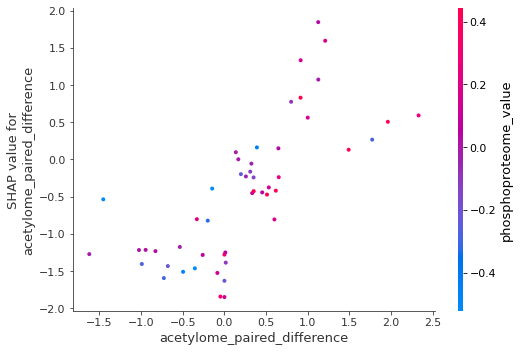

In [92]:
shap.dependence_plot("acetylome_paired_difference", shap_values[:50], test_X.iloc[:50, :])
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'dependence_plot.pdf'))

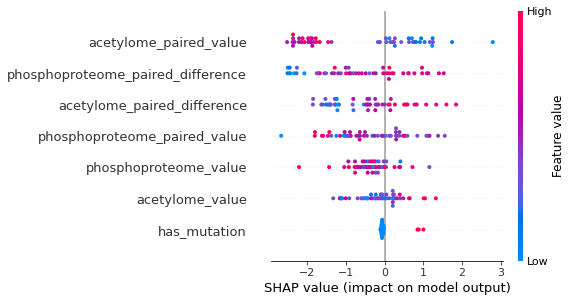

In [93]:
shap.summary_plot(shap_values[:50], test_X.iloc[:50, :])
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'summary_plot.pdf'))

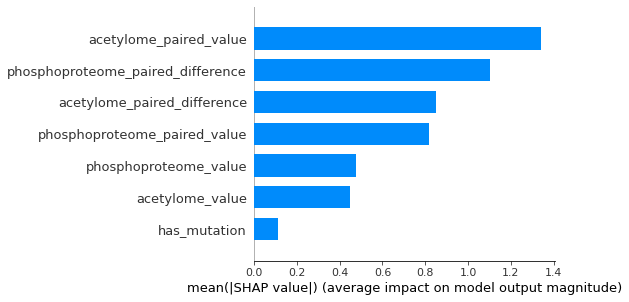

In [94]:
shap.summary_plot(shap_values[:50], test_X.iloc[:50, :], plot_type="bar")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'overall_feature_importances.pdf'))

In [ ]:
X,y = shap.datasets.boston()
# model = xgb.train({"learning_rate": 0.01}, xgb.DMatrix(X, label=y), 100)

In [ ]:
train_idxs = np.random.choice(np.arange(X.shape[0]), replace=False, size=int(X.shape[0] * .8)).flatten()
val_idxs = np.asarray([x for x in np.arange(X.shape[0]) if x not in train_idxs])

X_train, y_train = X.iloc[train_idxs, :], y[train_idxs]
X_val, y_val = X.iloc[val_idxs, :], y[val_idxs]

In [ ]:
X

In [ ]:
y

In [ ]:
clf = xgb.XGBRegressor(random_state=42)
model = clf.fit(X_train, y_train)

In [ ]:
# model = xgb.fit({"learning_rate": 0.01}, xgb.DMatrix(X[train_idxs], label=y[train_idxs]), 100)

In [ ]:
booster = model.get_booster()

model_bytearray = booster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
booster.save_raw = myfun

# Shap explainer initilization
# shap_ex = shap.TreeExplainer(mybooster)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X)